_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 256, 256, 6)       0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 256, 256, 64)      3520      
_________________________________________________________________
batch_normalization_103 (Bat (None, 256, 256, 64)      256       
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_104 (Bat (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 128, 128, 128)     73856     
__________

y_hat mean:0.081879 median:0.024828
Sensitive TP/(TP+FN) : 0.660000
              precision    recall  f1-score   support

           0       0.66      0.66      0.66       100
           1       0.66      0.66      0.66       100

   micro avg       0.66      0.66      0.66       200
   macro avg       0.66      0.66      0.66       200
weighted avg       0.66      0.66      0.66       200

y_hat mean:0.086275 median:0.033313
Sensitive TP/(TP+FN) : 0.630000
              precision    recall  f1-score   support

           0       0.63      0.63      0.63       100
           1       0.63      0.63      0.63       100

   micro avg       0.63      0.63      0.63       200
   macro avg       0.63      0.63      0.63       200
weighted avg       0.63      0.63      0.63       200

y_hat mean:0.077396 median:0.028229
Sensitive TP/(TP+FN) : 0.630000
              precision    recall  f1-score   support

           0       0.63      0.63      0.63       100
           1       0.63      0.63

y_hat mean:0.087927 median:0.025086
Sensitive TP/(TP+FN) : 0.670000
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       100
           1       0.67      0.67      0.67       100

   micro avg       0.67      0.67      0.67       200
   macro avg       0.67      0.67      0.67       200
weighted avg       0.67      0.67      0.67       200

y_hat mean:0.089262 median:0.029138
Sensitive TP/(TP+FN) : 0.610000
              precision    recall  f1-score   support

           0       0.61      0.61      0.61       100
           1       0.61      0.61      0.61       100

   micro avg       0.61      0.61      0.61       200
   macro avg       0.61      0.61      0.61       200
weighted avg       0.61      0.61      0.61       200

y_hat mean:0.071535 median:0.027930
Sensitive TP/(TP+FN) : 0.680000
              precision    recall  f1-score   support

           0       0.68      0.68      0.68       100
           1       0.68      0.68

y_hat mean:0.084363 median:0.029533
Sensitive TP/(TP+FN) : 0.690000
              precision    recall  f1-score   support

           0       0.69      0.69      0.69       100
           1       0.69      0.69      0.69       100

   micro avg       0.69      0.69      0.69       200
   macro avg       0.69      0.69      0.69       200
weighted avg       0.69      0.69      0.69       200

y_hat mean:0.091872 median:0.034089
Sensitive TP/(TP+FN) : 0.610000
              precision    recall  f1-score   support

           0       0.61      0.61      0.61       100
           1       0.61      0.61      0.61       100

   micro avg       0.61      0.61      0.61       200
   macro avg       0.61      0.61      0.61       200
weighted avg       0.61      0.61      0.61       200

y_hat mean:0.067754 median:0.026815
Sensitive TP/(TP+FN) : 0.700000
              precision    recall  f1-score   support

           0       0.70      0.70      0.70       100
           1       0.70      0.70

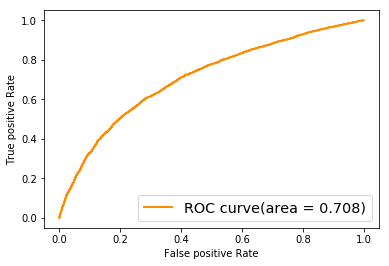

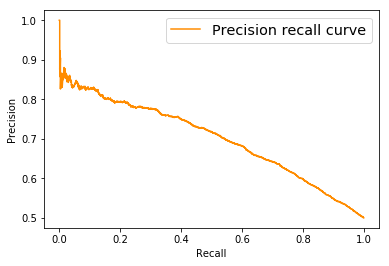

In [14]:
from __future__ import division
import json
from pprint import pprint
import pickle
import matplotlib.pyplot as plt
from plotLayer import *
from preprocess import *
import os
import time
import numpy as np
import glob
from scipy import sparse as sp
from skimage.measure import block_reduce
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, precision_recall_curve

from model import *
from keras.backend.tensorflow_backend import set_session

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


def Classify_Rate(y, y_hat):
    # True Positive (TP): we predict a label of 1 (positive), and the true label is 1.
    TP = np.sum(np.logical_and(y_hat == 1, y == 1))
    # True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
    TN = np.sum(np.logical_and(y_hat == 0, y == 0))
    # False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
    FP = np.sum(np.logical_and(y_hat == 1, y == 0))
    # False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
    FN = np.sum(np.logical_and(y_hat == 0, y == 1))
    return TP, TN, FP, FN


def Predict(model, x, y_threshold=None):
    y_hat = model.predict(x)

    if y_threshold :
        y_hat[y_hat < y_threshold] = 0
        y_hat[y_hat >= y_threshold] = 1
    return y_hat

def PlotROC(y, y_hat):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y, y_hat)
        roc_auc[i] = auc(fpr[i], tpr[i])
    print ("roc_auc_score:%f" %roc_auc_score(y, y_hat))
    plt.figure()
    plt.plot(fpr[1], tpr[1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.show()

def PreprocessData(datapath, width=256, channel=6):
    ratio = 1024 // width
    with open(datapath, "rb") as f:
        data = pickle.load(f)
    x = np.heaviside(np.array([map(lambda x: block_reduce(x.toarray(), block_size=(ratio,ratio), func=np.max), d.hL) for d in data]), 0)
    x = np.swapaxes(x, 1, 3)
    y = np.array([d.label for d in data])
    return x, y


if __name__ == "__main__":
    width = 256
    channel = 6
    #classify_weights_path = "Classify_epoch_50_batch_4.hdf5" the below model is copied one directory above
    classify_weights_path = "Newmodel_Classify_epoch_50_batch_5.hdf5"


    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
    config.gpu_options.per_process_gpu_memory_fraction = 0.9
    sess = tf.Session(config=config)
    set_session(sess)

    classify_model = Encoder_Classify(input_size=(width,width,6), batch_normal=True)
    classify_model.load_weights(classify_weights_path)

    d0_path = "../Data/1stDataset/d0*"
    false_path = "../Data/1stDataset/false*"
    d0 = np.sort(glob.glob(d0_path))
    f0 = np.sort(glob.glob(false_path))

    y_total = []
    y_hat_total = []
    #proba is a keyword used in sklearn for probabilities
    proba = []
#     301
    for i in range(500,551):
        x1, y1 = PreprocessData(d0[i], width=width, channel=channel)
        x2, y2 = PreprocessData(f0[i], width=width, channel=channel)
        x = np.concatenate((x1, x2), axis=0)
        y = np.concatenate((y1, y2), axis=0)

        y_hat = Predict(classify_model, x)
#         print(y_hat)
        y_total += [y]
        y_hat_total += [y_hat]
        proba += [y_hat.copy()]
# print(proba)-------You should be very careful in numpy as numpy arrays as get cop
# https://jakevdp.github.io/PythonDataScienceHandbook/02.02-the-basics-of-numpy-arrays.html
# Check the section sub arrays as no copy views
        print("y_hat mean:%f median:%f" %(np.mean(y_hat), np.median(y_hat)))
        y_hat[y_hat < np.median(y_hat)] = 0
        y_hat[y_hat >= np.median(y_hat)] = 1

        TP, TN, FP, FN = Classify_Rate(y, y_hat)
        print("Sensitive TP/(TP+FN) : %f" %(TP / (TP + FN)))
        print(classification_report(y, y_hat))

    y = np.concatenate(y_total)
    y_hat = np.concatenate(y_hat_total)
    proba = np.concatenate(proba)
    a=np.hstack((y,proba))
    np.savetxt("newmodel_y_y_hat.txt",a,delimiter=',')
    print(y.shape)
    print(y_hat.shape)
    print("y_hat mean:%f median:%f" %(np.mean(y_hat), np.median(y_hat)))
    fp,tp,tr=roc_curve(y,proba)
    p,r,tr1=precision_recall_curve(y,proba)
    plt.figure(1)
    plt.plot(fp,tp,color='darkorange',lw=2,label='ROC curve(area = %0.3f)'%auc(fp,tp))
    plt.xlabel('False positive Rate')
    plt.ylabel('True positive Rate')
    legend = plt.legend(fontsize = 'x-large')
    plt.savefig('ROC_curve_newmodel.png')
    plt.show()
    plt.figure(2)
    plt.plot(r,p,color='darkorange', label='Precision recall curve') 
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    legend=plt.legend(fontsize='x-large')
    plt.savefig('Precision_Recall_newmodel.png')
    plt.show()

# ROC curve area = 0.708

In [16]:
    y_hat[y_hat < np.median(y_hat)] = 0
    y_hat[y_hat >= np.median(y_hat)] = 1
    TP, TN, FP, FN = Classify_Rate(y, y_hat)
    print("Sensitive TP/(TP+FN) : %f" %(TP / (TP + FN)))
    print(classification_report(y, y_hat))

Sensitive TP/(TP+FN) : 0.655098
              precision    recall  f1-score   support

           0       0.66      0.66      0.66      5100
           1       0.66      0.66      0.66      5100

   micro avg       0.66      0.66      0.66     10200
   macro avg       0.66      0.66      0.66     10200
weighted avg       0.66      0.66      0.66     10200



In [15]:
# print(proba)
# from sklearn.metrics import confusion_matrix
# tn, fp, fn, tp = confusion_matrix([0, 1, 0, 1], [0.8, 0.9, 0.85, 0]).ravel()
# What ever I have presented yesterday those contain thresholded values. 
# from sklearn.metrics import classification_report
# y_true=np.array([0,1,1,1,0,0,1])
# y_pred=np.array([0.3,0.9,0.8,0.3,0.2,0.3,0.8])
# print(classification_report(y_true, y_pred))
#Classification report as well as the confusion_matrix works only for a particular case.